97.3
163.0


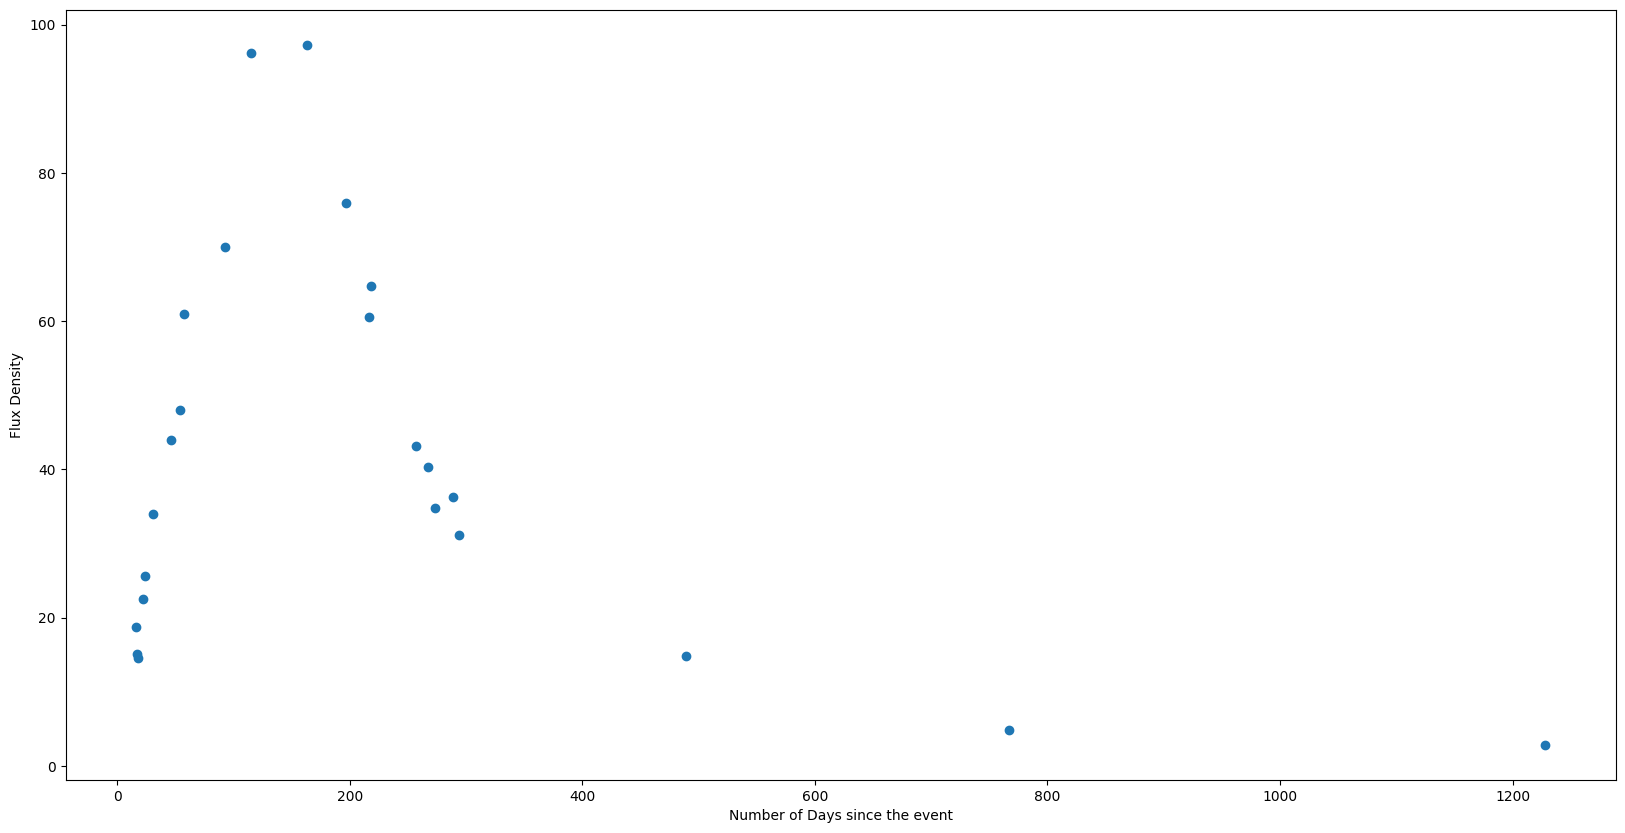

In [1]:
import numpy as np
from numpy import float64
import matplotlib.pyplot as plt
from astropy.io import ascii
from scipy.optimize import curve_fit
import scipy
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)

gw170817 = ascii.read('http://www.tauceti.caltech.edu/kunal/gw170817/gw170817_afterglow_data_full.txt')

gw170817 = gw170817.group_by('Telescope')

mask = gw170817.groups.keys['Telescope'] == 'VLA'

gw170817_vla = gw170817.groups[mask]

gw170817_vla = gw170817_vla.group_by('Freq')

mask = gw170817_vla.groups.keys['Freq'] == 3*(10**9)

gw170817_final = gw170817_vla.groups[mask]

plot_T = np.array(gw170817_final['T']).astype(float64)
plot_FluxD = np.array(gw170817_final['FluxD'])
FluxD_err = np.array(gw170817_final['FluxDErr'])
FluxD_err = np.delete(FluxD_err,[0,1])
plot_FluxD = np.delete(plot_FluxD,[0,1])
plot_T = np.delete(plot_T,[0,1])
plot_FluxD = plot_FluxD.astype(float64)
plt.xlabel("Number of Days since the event")
plt.ylabel("Flux Density")


print(plot_FluxD[11])
print(plot_T[11])
plt.scatter(plot_T, plot_FluxD)


[101.02640321 157.2991832    3.64095023   0.84914265  -2.0848578 ] [[ 2.97213319e+01 -2.23768512e+01  7.97955075e+00  6.76738865e-03
   7.84399212e-01]
 [-2.23768512e+01  3.52881344e+01 -6.65763933e+00 -6.13974100e-02
  -1.19352998e+00]
 [ 7.97955075e+00 -6.65763933e+00  2.98313639e+00 -3.18109081e-02
   3.14630222e-01]
 [ 6.76738865e-03 -6.13974100e-02 -3.18109081e-02  2.38519395e-03
  -1.60195356e-03]
 [ 7.84399212e-01 -1.19352998e+00  3.14630222e-01 -1.60195356e-03
   5.31349713e-02]]


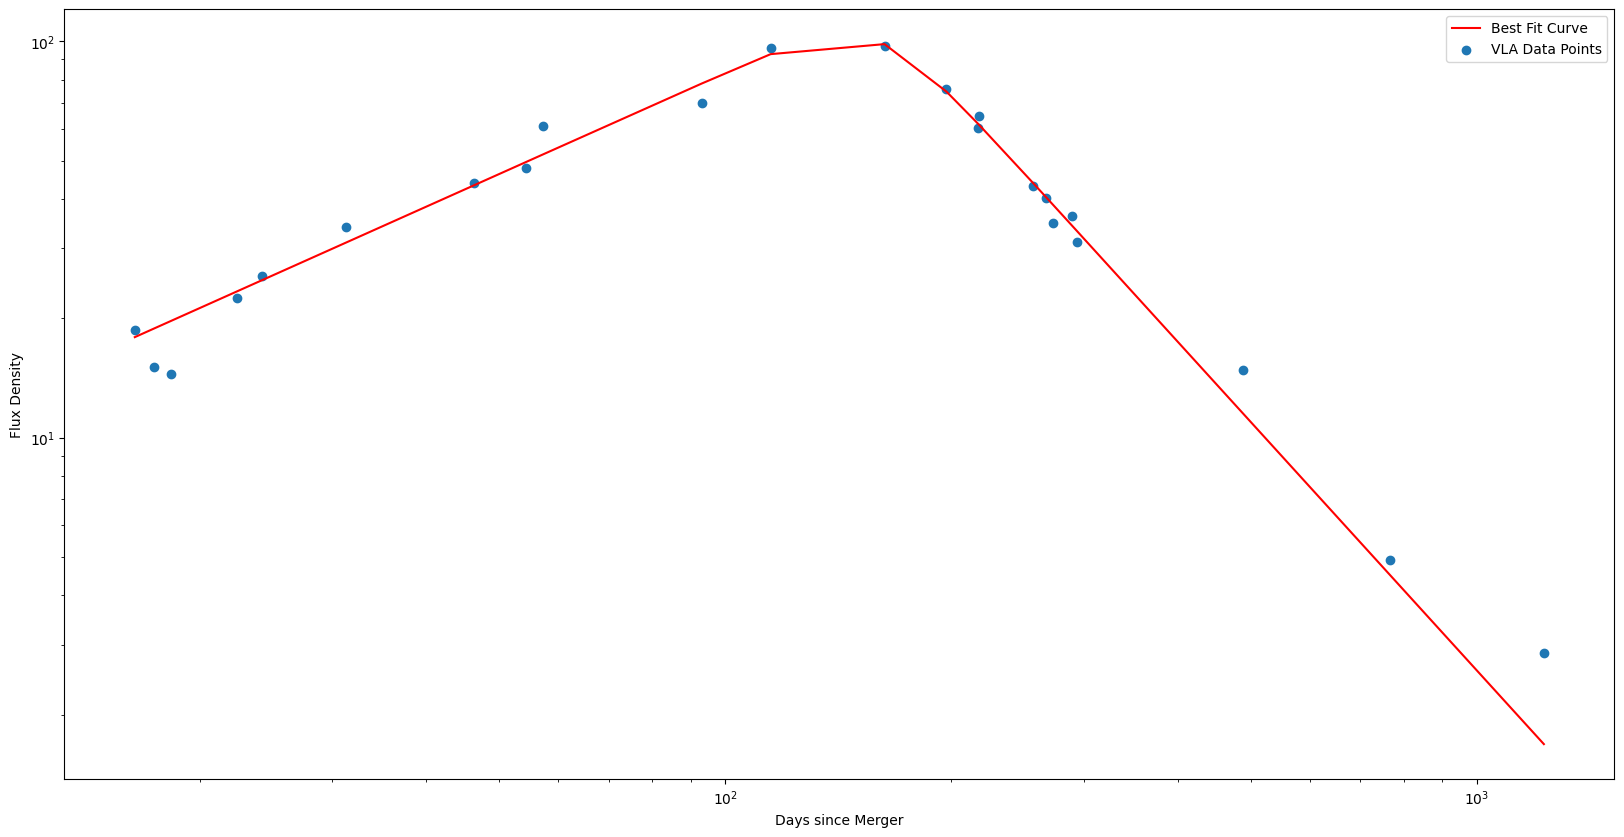

In [11]:
#Scipy Curvefit
def function(T,F,t,s,a_1,a_2):
    
    return (2**(1/s))*(F)*(((T/t)**(-s*a_1) + (T/t)**(-s*a_2))**(-1/s))

param, param_cov = curve_fit(function,plot_T,plot_FluxD,(97.3,163.0,1.0,1.0,-2.0))

print(param,param_cov)

plt.plot(plot_T, function(plot_T,101.02640321, 157.2991832, 3.64095023, 0.84914265,-2.0848578), color="red",label="Best Fit Curve")

plt.scatter(plot_T, plot_FluxD,label="VLA Data Points")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Days since Merger")
plt.ylabel("Flux Density")
plt.legend()

plt.savefig("BestFitGW170817.png")

Running burn-in...
Running production...


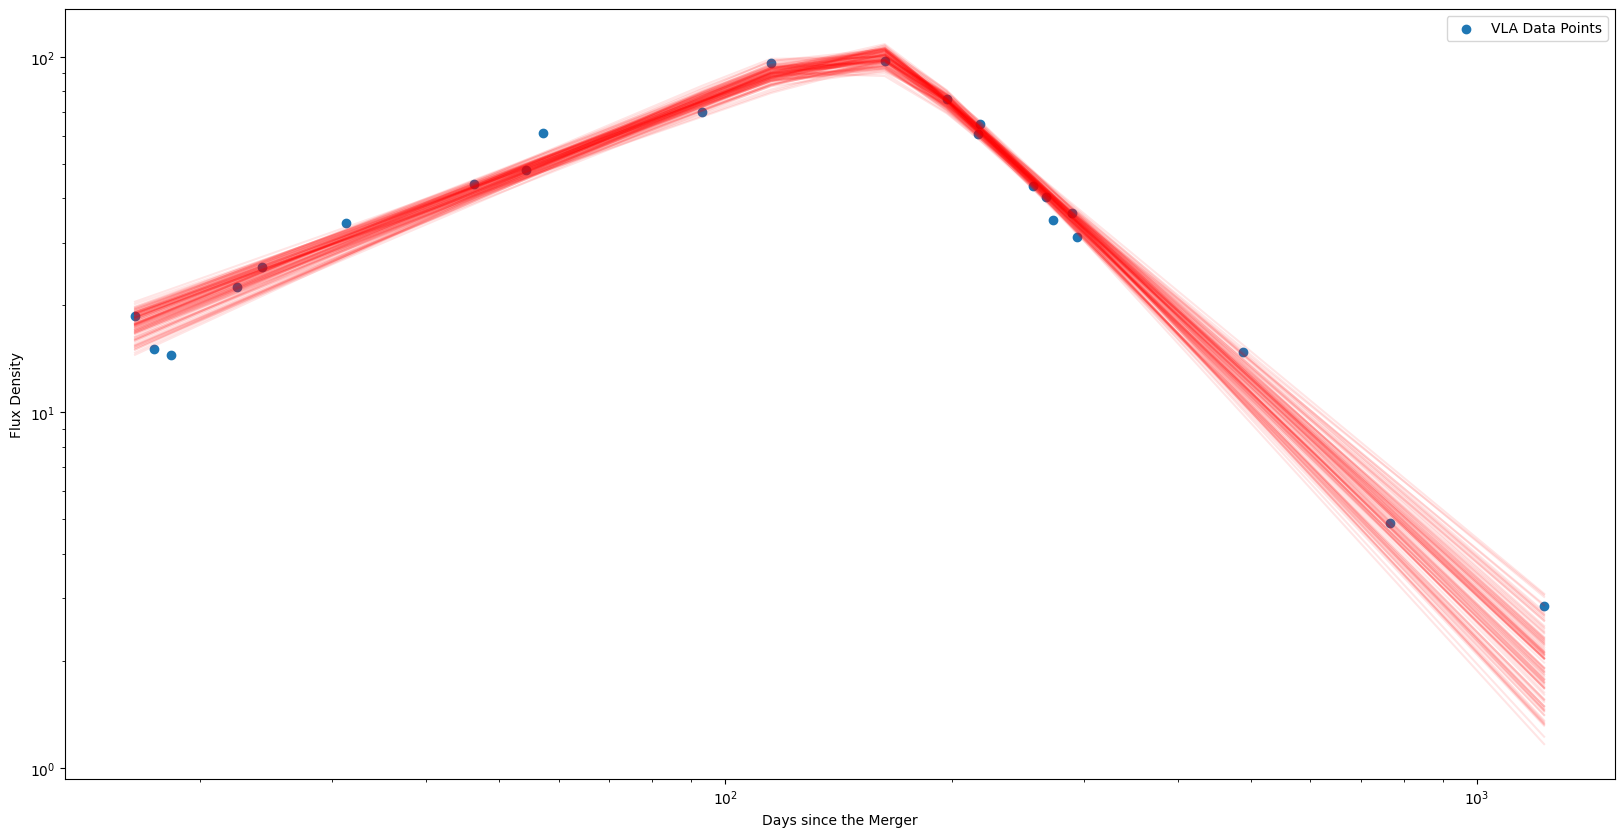

In [39]:
import emcee
import corner

def model(theta, T = plot_T):
    F,t,s,a_1,a_2 = theta
    return (2**(1/s))*(F)*(((T/t)**(-s*a_1) + (T/t)**(-s*a_2))**(-1/s))

def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model(theta, x))/yerr) ** 2)

def lnprior(theta):
    F,t,s,a_1,a_2 = theta
    if 90<F<110 and 150<t<180 and 0<s<10 and 0<a_1<5 and -5<a_2<0:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

err_FluxD = FluxD_err
data = (plot_T,plot_FluxD,err_FluxD)
nwalkers = 128
niter = 2000
initial = np.array([97.3, 163.0, 1.0, 1.0, -2.0])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state



sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)



def plotter(sampler,plot_T=plot_T,plot_FluxD=plot_FluxD):
    plt.ion()
    plt.scatter(plot_T,plot_FluxD,label="VLA Data Points")
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(plot_T, model(theta, plot_T), color="r", alpha=0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('Days since the Merger')
    plt.ylabel("Flux Density")
    plt.legend()
    
    plt.xscale('log')
    plt.yscale('log')
    
    plt.savefig("samplerplot.png")
    plt.show()

plotter(sampler)




In [40]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]

array([102.77202046, 156.81643614,   4.55191496,   0.84868256,
        -1.97874251])

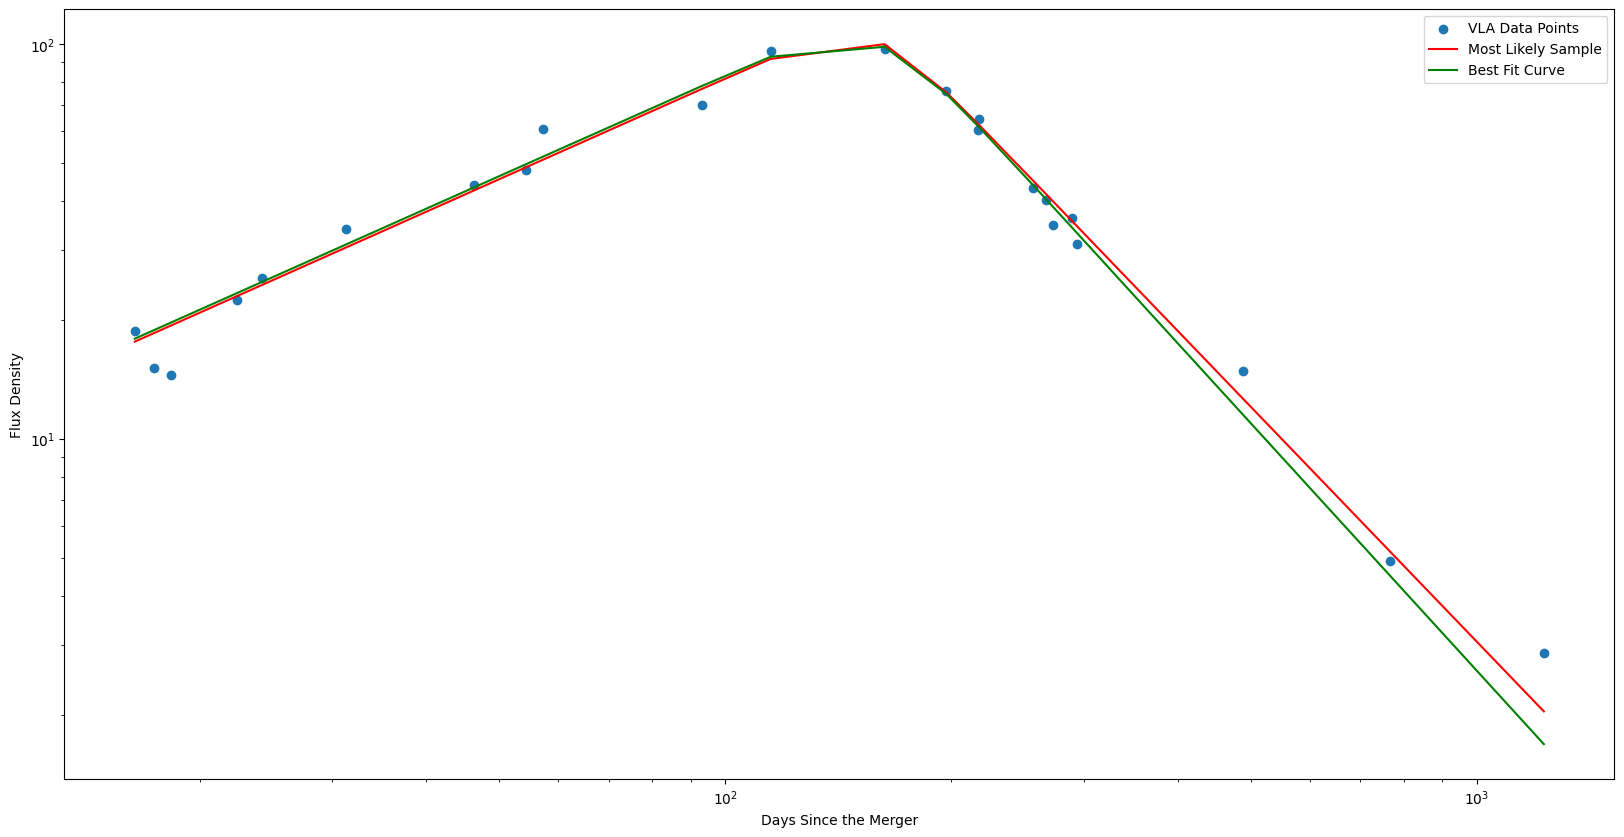

Theta max:  [102.77202046 156.81643614   4.55191496   0.84868256  -1.97874251]


In [41]:
samples = sampler.flatchain

theta_max  = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = model(theta_max)
plt.scatter(plot_T,plot_FluxD,label="VLA Data Points")
plt.plot(plot_T,best_fit_model,label="Most Likely Sample",color="red")

plt.plot(plot_T, function(plot_T,101.02640321, 157.2991832, 3.64095023, 0.84914265,-2.0848578), color="green",label="Best Fit Curve")


plt.xlabel("Days Since the Merger")
plt.ylabel("Flux Density")
plt.xscale('log')
plt.yscale('log')


plt.legend()
plt.savefig("mostlikely.png")
plt.show()
print ('Theta max: ',theta_max)




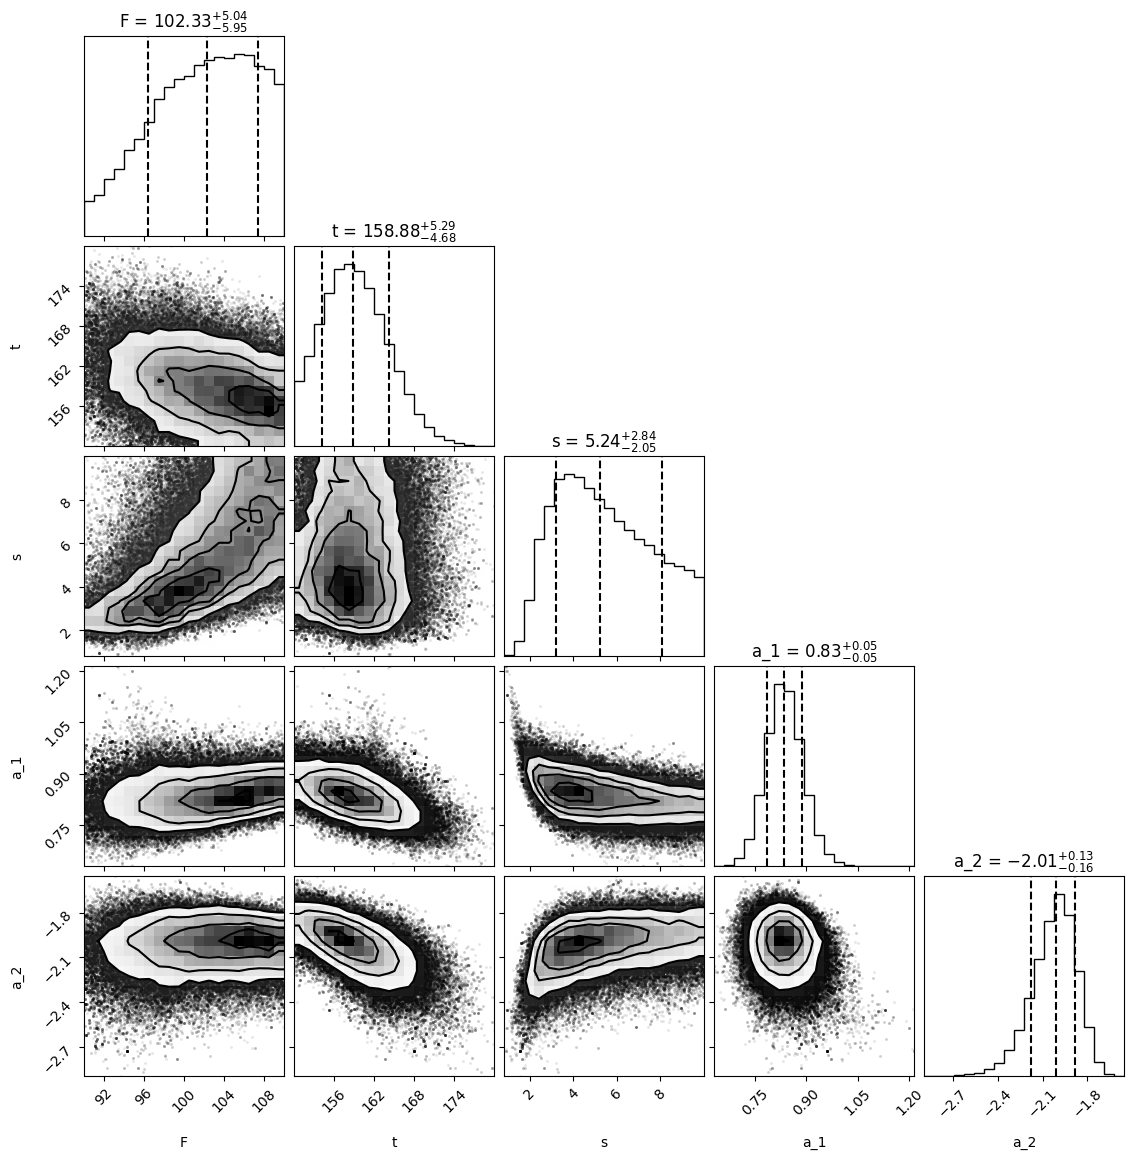

In [42]:
labels = ['F','t','s','a_1','a_2']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

